# Human Silhouettes Detector
---
Detector of human sulhouettes.

In [1]:
import os
import csv
import numpy as np
import pandas as pd

import pickle

from PIL import Image

from src.human_silhouette_detector import (detect_human_silhouettes,
                                           detect_human_silhouettes_and_faces)
from src.face_detector import inference
from src.perc_calculation import intersects

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'MainModel.KitModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original sou

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
def show_images(images, titles, suptitle='Images'):
    assert (len(images) == len(titles)), 'Lists of images and titles of images must have the same length!'
    
    fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
    
    for i, (image, title) in enumerate(zip(images, titles)):
        ax[i].imshow(image)
        ax[i].set_title(title)
        ax[i].axis('off')
    
    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

In [4]:
img1 = Image.open('images/unmasked_people1.jpg')
img1_info, img1 = detect_human_silhouettes(img1)

img2 = Image.open('images/unmasked_people2.jpg')
img2_info, img2 = detect_human_silhouettes(img2)

img3 = Image.open('images/unmasked_people3.jpg')
img3_info, img3 = detect_human_silhouettes(img3)

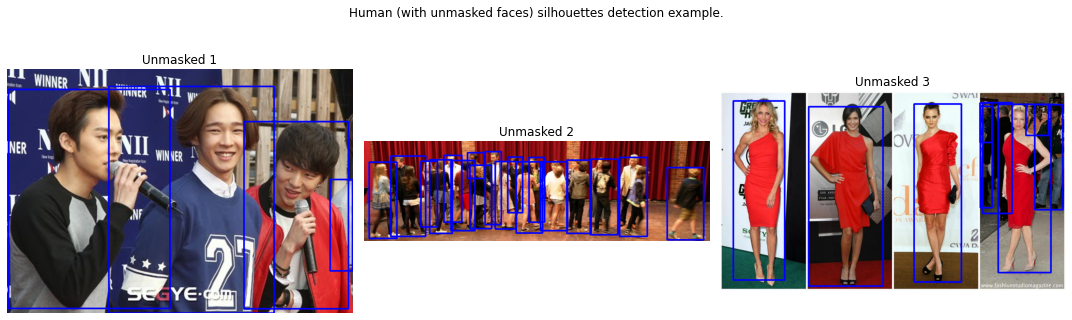

In [5]:
show_images([img1, img2, img3],
            ['Unmasked 1', 'Unmasked 2', 'Unmasked 3'],
            suptitle='Human (with unmasked faces) silhouettes detection example.')

In [6]:
img1 = Image.open('images/masked_people1.jpg')
img1_info, img1 = detect_human_silhouettes(img1)

img2 = Image.open('images/masked_people2.jpg')
img2_info, img2 = detect_human_silhouettes(img2)

img3 = Image.open('images/masked_people3.jpg')
img3_info, img3 = detect_human_silhouettes(img3)

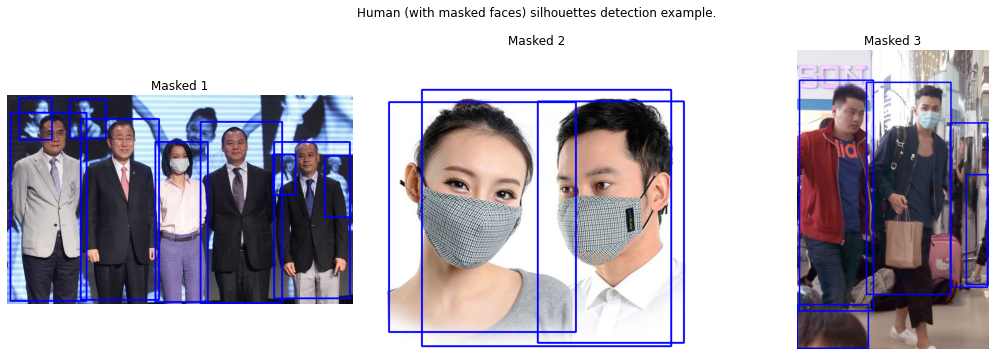

In [7]:
show_images([img1, img2, img3],
            ['Masked 1', 'Masked 2', 'Masked 3'],
            suptitle='Human (with masked faces) silhouettes detection example.')

In [8]:
img1 = Image.open('images/masked_criminal1.png')
img1_info, img1 = detect_human_silhouettes(img1)

img2 = Image.open('images/masked_criminal2.png')
img2_info, img2 = detect_human_silhouettes(img2)

img3 = Image.open('images/masked_criminal3.png')
img3_info, img3 = detect_human_silhouettes(img3)

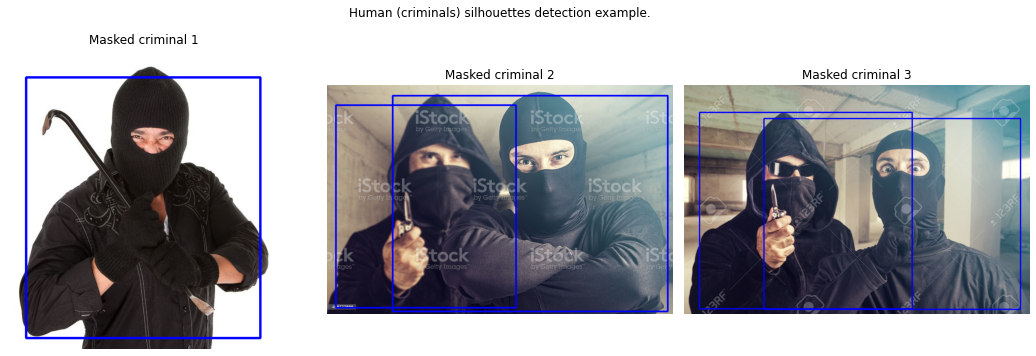

In [9]:
show_images([img1, img2, img3],
            ['Masked criminal 1', 'Masked criminal 2', 'Masked criminal 3'],
            suptitle='Human (criminals) silhouettes detection example.')

## Silhouette and face dependencies
---
Searching for dependencies between silhouette and face positions.
1. Save .csv header row \['img_name', 'silh_x1', 'silh_y1', 'silh_x2', 'silh_y2', 'faceimg_name', 'face_x1', 'face_y1', 'face_x2', 'face_y2'\].
2. For each image.png:
    1. Detect silhouettes.
    2. For each detected silhouette region:
        1. Detect faces.
        2. For each detected face region:
            1. Save detected face as face_x.png.
            2. Save .csv row \['image.png', 'sx1', 'sy1', 'sx2', 'sy2', 'face_x.png', 'fx1', 'fy1', 'fx2', 'fy2'\].

In [10]:
IMG_FOLDER = 'silh_images'
FACES_FOLDER = 'detected_faces'
OUT_CSV = 'silhfaces_positions.csv'

In [11]:
if not os.path.exists(OUT_CSV):
    with open(OUT_CSV, 'w') as f:
        csv.writer(f).writerow(['img_name', 'silh_x1', 'silh_y1', 'silh_x2', 'silh_y2',
                               'faceimg_name', 'face_x1', 'face_y1', 'face_x2', 'face_y2'])
    ctr = 0
    t = tqdm(sorted(os.listdir(IMG_FOLDER)))
    for img_name in t:
        
        t.set_postfix_str(f'Curr. img.: {img_name} | Faces found: {ctr}')
        img = Image.open(f'{IMG_FOLDER}/{img_name}')
        img_arr = np.array(img)
        
        try:
            silhs, _ = detect_human_silhouettes(img_arr)
            faces, _ = inference(img_arr)
            for face in faces:
                fx1, fy1, fx2, fy2 = tuple(face[2:])
                
                face_path = f'{FACES_FOLDER}/face{ctr}.png'
                face_img = Image.fromarray(img_arr[fy1:fy2, fx1:fx2])
                face_img.save(face_path)
                for silh in silhs:
                    x1, y1, x2, y2 = tuple(np.array(silh, dtype=np.int32))
                    
                    # if exists intersection between silhouette and face rectangles
                    if intersects(x1, y1, x2, y2, fx1, fy1, fx2, fy2):
                        with open(OUT_CSV, 'a') as f:
                            csv.writer(f).writerow([img_name, x1, y1, x2, y2,
                                                    f'face{ctr}.png', fx1, fy1, fx2, fy2])
                ctr += 1
        except:
            pass

Annotate detected faces whether:
 - **-1** - it's not a face
 - **0** - it's a face without mask or uncorrectly put on mask
 - **1** - it's a face with correctly put on mask

Train DecisionTree model to predict (having two points of silhouette and two of potential face) whether the detection is face or not.

In [12]:
POSITIONS_CSV = 'silhfaces_positions.csv'
ANNOTATIONS_CSV = 'detected_faces_annotations.csv'

MM_SC_PATH = 'src/models/mm_sc.pkl'
DT_POS_PATH = 'src/models/dt_pos.pkl'

In [13]:
df_positions = pd.read_csv(POSITIONS_CSV)
df_positions.head(2)

,img_name,silh_x1,silh_y1,silh_x2,silh_y2,faceimg_name,face_x1,face_y1,face_x2,face_y2
0,13_Interview_Interview_2_People_Visible_13_101...,14,6,406,684,face0.png,149,85,303,281
1,13_Interview_Interview_2_People_Visible_13_101...,369,173,864,683,face1.png,542,220,717,446


In [14]:
df_annotations = pd.read_csv(ANNOTATIONS_CSV)
df_annotations.head(2)

,File,Class
0,face0.png,0
1,face1.png,0


In [15]:
df_combine = df_positions.merge(df_annotations, left_on='faceimg_name',
                                right_on='File').drop(['img_name', 'faceimg_name', 'File'], axis=1)
df_combine['Class'] = df_combine['Class'].map({-1: 0, 0: 1, 1: 1})  # 0 - no face; 1 - face
df_combine = df_combine.sample(frac = 1) 
df_combine

,silh_x1,silh_y1,silh_x2,silh_y2,face_x1,face_y1,face_x2,face_y2,Class
833,443,10,690,495,281,34,450,232,1
246,711,41,1024,633,740,379,857,481,0
1036,45,7,588,446,142,78,398,343,1
1350,51,192,288,721,115,215,186,314,1
693,832,1,1013,315,854,11,944,93,0
...,...,...,...,...,...,...,...,...,...
718,526,9,944,358,647,54,757,211,1
214,622,262,1008,665,681,287,838,495,1
584,315,79,686,505,463,97,545,200,1
1427,379,95,879,619,432,230,463,272,1


In [16]:
if not os.path.exists(MM_SC_PATH):
    sc_x, sc_y = MinMaxScaler(), MinMaxScaler()
    silh_x = sc_x.fit_transform(df_combine[['silh_x1', 'silh_x2']].values)
    silh_y = sc_y.fit_transform(df_combine[['silh_y1', 'silh_y2']].values)
    face_x = sc_x.transform(df_combine[['face_x1', 'face_x2']].values)
    face_y = sc_y.transform(df_combine[['face_y1', 'face_y2']].values)
    
    with open(MM_SC_PATH, 'wb') as f:
        pickle.dump([sc_x, sc_y], f)
else:
    with open(MM_SC_PATH, 'rb') as f:
        sc_x, sc_y = tuple(pickle.load(f))
    silh_x = sc_x.transform(df_combine[['silh_x1', 'silh_x2']].values)
    silh_y = sc_y.transform(df_combine[['silh_y1', 'silh_y2']].values)
    face_x = sc_x.transform(df_combine[['face_x1', 'face_x2']].values)
    face_y = sc_y.transform(df_combine[['face_y1', 'face_y2']].values)

In [17]:
df_combine['silh_x1'] = silh_x[:, ::2].reshape(-1)
df_combine['silh_y1'] = silh_y[:, ::2].reshape(-1)
df_combine['silh_x2'] = silh_x[:, 1::2].reshape(-1)
df_combine['silh_y2'] = silh_y[:, 1::2].reshape(-1)

df_combine['face_x1'] = face_x[:, ::2].reshape(-1)
df_combine['face_y1'] = face_y[:, ::2].reshape(-1)
df_combine['face_x2'] = face_x[:, 1::2].reshape(-1)
df_combine['face_y2'] = face_y[:, 1::2].reshape(-1)

df_combine

,silh_x1,silh_y1,silh_x2,silh_y2,face_x1,face_y1,face_x2,face_y2,Class
833,0.399819,0.010320,0.363167,0.153476,0.253610,0.035088,0.225473,0.056213,1
246,0.641697,0.042312,0.554791,0.204512,0.667870,0.391125,0.458979,0.148299,0
1036,0.040614,0.007224,0.304647,0.135355,0.128159,0.080495,0.195640,0.097263,1
1350,0.046029,0.198142,0.132530,0.237056,0.103791,0.221878,0.074010,0.086538,1
693,0.750903,0.001032,0.548480,0.086908,0.770758,0.011352,0.508893,0.004808,0
...,...,...,...,...,...,...,...,...,...
718,0.474729,0.009288,0.508893,0.102811,0.583935,0.055728,0.401606,0.048447,1
214,0.561372,0.270382,0.545611,0.216346,0.614621,0.296182,0.448078,0.153476,1
584,0.284296,0.081527,0.360872,0.157175,0.417870,0.100103,0.279977,0.044379,1
1427,0.342058,0.098039,0.471601,0.199334,0.389892,0.237358,0.232932,0.071006,1


In [18]:
if not os.path.exists(DT_POS_PATH):
    X = df_combine.drop('Class', axis=1).values
    y = df_combine['Class'].values
    
    skf = StratifiedKFold(n_splits=5)
    
    best_mf, best_mnf = 0., 0.  # best mean and st.dev. f1

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = DecisionTreeClassifier(random_state=0, class_weight='balanced')
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        a = accuracy_score(y_true=y_test, y_pred=y_pred)
        f = f1_score(y_true=y_test, y_pred=y_pred, average=None, zero_division=1)

        mf = np.mean(f)
        mnf = np.min(f)
        # save model if mean and min f1 is better than previous value
        if mf > best_mf and mnf > best_mnf:
            best_mf = mf
            best_mnf = mnf

            print(f'TEST IDX: [{test_index[0]}:{test_index[-1]}] | Acc.: {a} | F1: {f} --> Saved!')

            with open('src/models/dt_pos.pkl', 'wb') as f:
                pickle.dump(clf, f)
        else:
            print(f'TEST IDX: [{test_index[0]}:{test_index[-1]}] | Acc.: {a} | F1: {f}')

In [19]:
a = np.array([[1]])
a.flatten()[0]

1

### Examples

In [20]:
img1 = Image.open('images/unmasked_people1.jpg')
img1_pos, img1_neg, img1 = detect_human_silhouettes_and_faces(img1, highlight_neg=True)

img2 = Image.open('images/unmasked_people2.jpg')
img2_pos, img2_neg, img2 = detect_human_silhouettes_and_faces(img2, highlight_neg=True)

img3 = Image.open('images/unmasked_people3.jpg')
img3_pos, img3_neg, img3 = detect_human_silhouettes_and_faces(img3, highlight_neg=True)

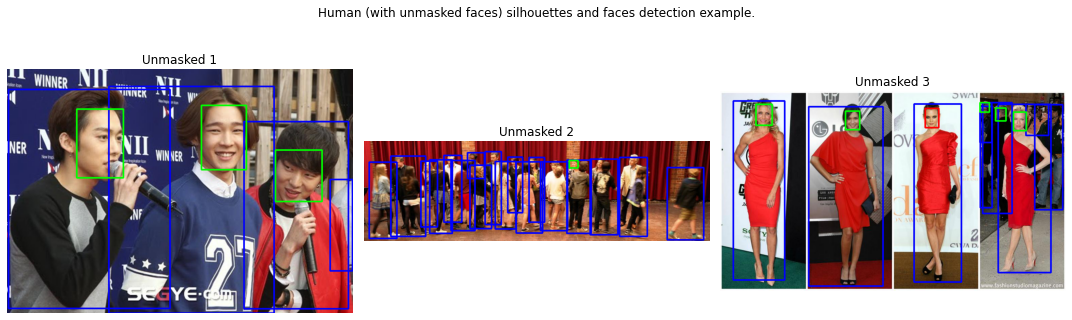

In [21]:
show_images([img1, img2, img3],
            ['Unmasked 1', 'Unmasked 2', 'Unmasked 3'],
            suptitle='Human (with unmasked faces) silhouettes and faces detection example.')

In [22]:
img1 = Image.open('images/masked_people1.jpg')
img1_pos, img1_neg, img1 = detect_human_silhouettes_and_faces(img1, highlight_neg=True)

img2 = Image.open('images/masked_people2.jpg')
img2_pos, img2_neg, img2 = detect_human_silhouettes_and_faces(img2, highlight_neg=True)

img3 = Image.open('images/masked_people3.jpg')
img3_pos, img3_neg, img3 = detect_human_silhouettes_and_faces(img3, highlight_neg=True)

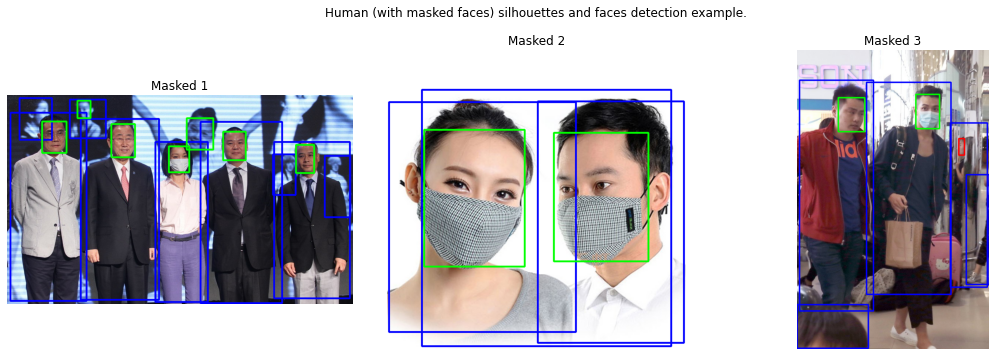

In [23]:
show_images([img1, img2, img3],
            ['Masked 1', 'Masked 2', 'Masked 3'],
            suptitle='Human (with masked faces) silhouettes and faces detection example.')

In [24]:
img1 = Image.open('images/masked_criminal1.png')
img1_pos, img1_neg, img1 = detect_human_silhouettes_and_faces(img1, highlight_neg=True)

img2 = Image.open('images/masked_criminal2.png')
img2_pos, img2_neg, img2 = detect_human_silhouettes_and_faces(img2, highlight_neg=True)

img3 = Image.open('images/masked_criminal3.png')
img3_pos, img3_neg, img3 = detect_human_silhouettes_and_faces(img3, highlight_neg=True)

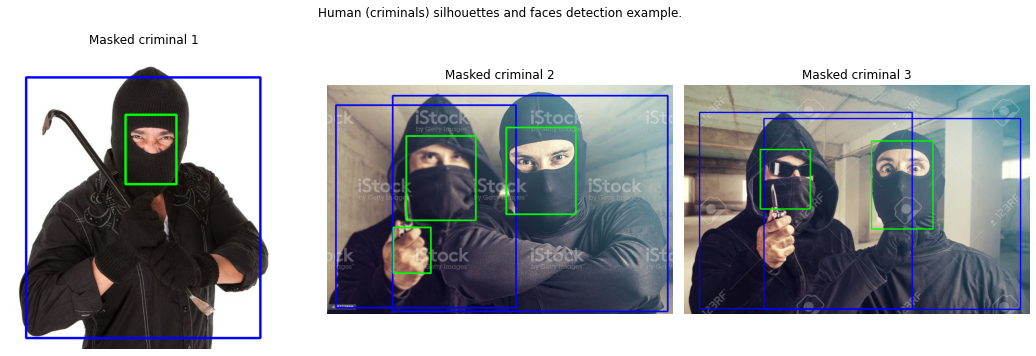

In [25]:
show_images([img1, img2, img3],
            ['Masked criminal 1', 'Masked criminal 2', 'Masked criminal 3'],
            suptitle='Human (criminals) silhouettes and faces detection example.')